## Setup

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

In [2]:
RANDOM_SEED=42

## <a id="anchortext" />Random Forest (RF)

Best described as 'An ensemble of Decision Trees'.  Which means that a Random forest is composed of decision trees<br>
**Advantages**
<ul>
    <li>fast
    <li>flexible
    <li>dont have many parameters to tune
    <li>can use to predict a number (like linear regression)
    <li>can use to predict a class (like logistic regression)
</ul>

**Intution**
"If you have a model that's terrible, but is better than random.And if you can make thousands of these models that are all terrible in different ways (they are not correlated with each other).  Then the average of those 1000’s of models will be very accurate since the model errors tend to cancel each other." Much like the wisdom of crowds.<br><br>

**Details: Random Subspaces**    
Each tree is constructed from a <mark>Random Subspace</mark> (rows and columns) of the original dataset (makes each tree different or less correated with other trees). Random subspaces are not contiguous, just a random sample.<br>
![](./random_subspace.png)
<br>

**Details: Building each Tree**  
What differs from regular decision trees, is that at each split point, <mark>a random set of the subspaces features (columns) are chosen to determine which feature to split on</mark>.  In other words it does NOT choose the best column from all available columns.  This further decreases correlation amongst the Trees.<br>
Increase randomness more by using extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes). Instead of splitting on the perfect point for continuous vars (or other vars), select a few points withen range and randomly choose one.  You dont get the best information gain, but you avoid the problem where you are splitting on the same number for every tree which leads to higher correlations between trees.  This makes each tree less effecient at partitioning the data but this effect is negated by averaging enough trees together.<br>

**Predition**
To predict, have all trees make a prediction on a given row of data, then;<br>
 *If Regressing* output the average of all tree predictions<br>
 *If Classifying* output the class chosen by majority of trees<br>
 
 **Hyperparameters** some important ones <br>
 *Depth*: Deeper trees tend to overfit to the training data, but are less correlated with each other, which in turn may improve the performance of the ensemble. Depths from 1 to 10 levels may be effective.<br>

 *Number of Trees* The more trees the better the model (at some point adding more trees does not boost the accuracy of the model though).  Trees are fast to create and can be done in parrallel, so training a model is generally very fast.<br>
 


Note: See [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for below code

## RF Regression
You can use random forest to predict a number

In [3]:
from sklearn.datasets import make_regression
# define dataset
X, y = make_regression(n_samples=1000, n_features=10, n_informative=7, noise=0.1, random_state=RANDOM_SEED)

from sklearn.ensemble import RandomForestRegressor

# define the model
clf = RandomForestRegressor()

#fit it
clf.fit(X,y)

#predict
print(clf.predict([[0,1,2,3,4,5,6,7,8,9]]))

RandomForestRegressor()

[117.1224599]


## RF Classification
You can use random forest to classify data

In [4]:
#make a dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=7, n_redundant=3, random_state=RANDOM_SEED,n_classes=5)

from sklearn.ensemble import RandomForestClassifier

# define the model
clf = RandomForestClassifier(max_depth=5, random_state=0)

#fit it
clf.fit(X,y)

#predict
print(clf.predict([[0,1,2,3,4,5,6,7,8,9]]))

RandomForestClassifier(max_depth=5, random_state=0)

[3]


## Out Of Band Error (OOB)
OOB score calculated for each row using Trees that did not train with the row. Average OOB score is the average of all row OOB scores.<br>
For example, see below for the OOB error generated using the Random subspaces illustrated under [Details:Random Subspaces](#anchortext) above<br>
![](./oob.png)
<br>



You can use this to tune your forest, for instance.  The number of trees you create, or the max_depth that each tree can be<br>
See [OOB Errors for Random Forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html?highlight=randomforestclassifier).  
The only problem is that scikit learns  RandomForestClassifier, and RandomForestRegressor both hardcode the error metric, if that works for you, great. See below for how to seee the metric in the source code

<code> 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=0, oob_score=True)
clf.fit??  #look for the FIXME section
clf._set_oob_score_and_attributes?? #notice that you get accuracy score</code>

In [20]:
# clf = RandomForestClassifier(max_depth=5, random_state=0, oob_score=True)
# clf=clf.fit(X,y)
# # clf.fit??
# clf._set_oob_score_and_attributes??  #notice that you get accuracy score

## Determining minimum number of trees for this dataset
Test a range of trees to see where performence plateus.  You can do this with tree depth as well. In fact there are a bunch of other hyperparameters to adjust, we will return to how to automate this process when we discuss cross validation and hyperparameter tuning

In [10]:
# track errors here
# define dataset
X, y = make_classification(n_samples=500, n_features=25, n_clusters_per_class=1,n_informative=15,random_state=RANDOM_SEED)

error_rate={}
max_trees=100

# Range of `n_estimators` values to explore.
min_estimators = 12
max_estimators = 100

for i in range(min_estimators,max_estimators+1,5):
    # define the model
    clf = RandomForestClassifier(n_estimators=i,max_depth=5, max_features="sqrt",random_state=RANDOM_SEED, oob_score=True)
    _=clf.fit(X,y)
    
    #get the error
    oob_error = 1 - clf.oob_score_
    error_rate[i]=oob_error

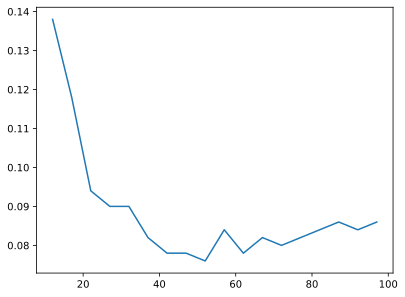

In [11]:
_=sns.lineplot(x=list(error_rate.keys()),y=list(error_rate.values()))

## You can see that, for this dataset, any number of trees >40 doesn't help